In [52]:
from functools import lru_cache
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def dataTransform(path)-> None:  # 对离散数据值进行转换
    data = pd.read_csv(path)
    data = data[['色泽','根蒂','敲声','纹理','脐部','触感','密度','含糖率','好瓜']]
    returndata = []
    for datai in data.values:
        temp =[]
        for dataii in datai:
            if dataii in ['青绿','蜷缩','清脆','清晰','平坦','硬滑','否']:
                temp.append(0.0)
            elif dataii in ['乌黑','稍蜷','浊响','稍糊','稍凹']:
                temp.append(0.5)
            elif isinstance(dataii,float) == True:
                temp.append(dataii)
            else:
                temp.append(1.0)
        returndata.append(temp)
    return returndata
# np.array(dataTransform())

def sigmoid(z):
	return 1.0 / (1 + np.exp(-z))

**输入**：

训练集$D = \{(\boldsymbol {x}_{1},y_{1}),...,(\boldsymbol {x}_{m},y_{m})\};$

属性集 $A =\{ a_{1},a_{2},...a_{d}\}$

**输出**：
以 `node` 为根节点的一颗决策树


In [53]:
import logging
import time
import numpy as np
import pandas as pd

def log(func):
    def wrapper(*args,**kwargs):
        start_time = time.time()
        logging.log(1,'start %s()'%func.__name__)
        ret = func(*args,**kwargs)
        end_time = time.time()
        logging.log(1,"end %s()\ncost:%d s"%(func.__name__,end_time-start_time))
        return ret
    return wrapper


def See(A):# 目前无法解决传入参数为 np.ndarry
    if A in (None,'',{},[],np.empty):
        print('variate is NULL')
    print('\ntype:%s \nvalue:%s\n'%(type(A),A))

'''
    函数: check
    功能: 查看属性值是否在集合 D 中, 不存在则报错
'''
def check(D:pd.DataFrame, *key):
    for item in key:
        if item not in D.columns:
            raise KeyError("%s isn't a keyword in %s"%(item,str(D.columns)))


In [71]:
class Node(object):                                 # 节点信息
    def __init__(self,
        parent:str,
        w:str = None,
        value:str = "",
        child:set = {},
        ) -> None:
        self.parent = parent                        # 父亲结点，若为根节点则为 None
        self.w = w                                  # 父亲结点对该节点的权值                 
        self.value = value                          # 节点的值
        self.child = child                          # 孩子节点，若为叶子结点则为空字典

class decisionTree(object):
    def __init__(self) -> None:                      # 初始为空树，即 0 个节点
        self.Node = None

    '''
        函数: infoEntropy_D
        输入: (D:样本集合, judge: 决策属性)。
            如一颗是不是'好瓜'的决策树, 则'好瓜'属性为决策属性, 将决策结果分为'好瓜类'和'坏瓜类'。
        输出: D 的信息熵
    '''

    def Entropy_D(
        self,
        D:pd.DataFrame,
        judge:str
        )->float:
        
        check(D, judge)
        D = np.array(D[judge][::])                               # 将集合 D 转换为 ndarray类型
        y_classes = np.unique(D)                                 # 样本集合 D 的类别数
        # print(D)
        Ent_D = 0                                                # D 的信息熵
        for i in y_classes:
            Di = float(D[D==i].size)            #  i 类所占数量                                   
            p_k = Di/D.size                     # i 类样本所占比例
            Ent_D -= p_k*np.log2(p_k)
        return Ent_D

    '''
        函数: infoGain_Da
        输入: (D: 样本集合, judge: 决策属性, a:划分属性)。
            如一颗是不是'好瓜'的决策树, 则'好瓜'属性为决策属性, 将决策结果分为'好瓜类'和'坏瓜类'。 
        输出: 属性 a 对样本 D 进行划分所获得的信息增益
    '''
    def Gain_Da(
        self,
        D:pd.DataFrame,
        judge:str,
        a:str)->float:

        check(D,judge,a)
        Ent_D = self.Entropy_D(D,judge)                           # D 的信息熵
         # 以 a 属性分割样本集合 D，并计算信息增益
        a_classes = np.unique(np.array(D[a][::]))
        D_len = len(D.values)
        H_Da = 0                                                # 经验条件熵
        for Di in a_classes:
            Di = D[D[a].isin([Di])]                             # 分割子集
            Ent_Di = self.Entropy_D(Di,judge)               # 计算 Di 子集的信息熵
            H_Da += (len(Di.values)/D_len) * Ent_Di             # 累加求和
        return Ent_D - H_Da


    def Gini_D(
        self,
        D:pd.DataFrame,
        judge:str)->float:

        D = np.array(D[judge][::])                               # 将集合 D 转换为 ndarray类型
        y_classes = np.unique(D)                                 # 样本集合 D 的类别数
        pk2 = 0
        for i in y_classes:
            pk2 +=  pow(float(D[D==i].size/D.size),2)
            # print(pk2)
        return 1 - pk2
    '''
        函数: Gini_Da
        输入: (D: 样本集合, judge: 决策属性, a:划分属性)。
            如一颗是不是'好瓜'的决策树, 则'好瓜'属性为决策属性, 将决策结果分为'好瓜类'和'坏瓜类'。
        输出: 属性 a 对样本 D 进行划分所获得的的基尼指数
    '''
    def Gini_index_Da(
        self,
        D:pd.DataFrame,
        judge:str,
        a:str)->float:

        check(D, judge, a)
        a_classes = np.unique(np.array(D[a][::]))

        Gini_index = 0
        for Dv in a_classes:
            Dv = D[D[a].isin([Dv])]     # 分割子集
            
            Gini_index += (Dv.size/D.size) * self.Gini_D(Dv,judge) 
        return Gini_index


    '''
        函数: TreeGenerate
        输入: (D: 样本训练集合, A: 属性集)
        输出: 以 node 为根节点的一颗决策树
    '''
    def TreeGenerate(
        self,
        D:pd.DataFrame,
        A:np.ndarray)->Node:

        node = Node(None)       # 生成一个根节点


In [72]:
data = pd.read_csv('../datasets/watermelon.csv')
dTree = decisionTree()
data.columns
dTree.Gini_index_Da(data,'好瓜','纹理')

0.2771241830065359

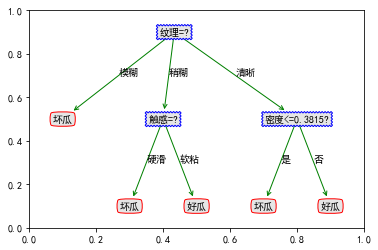

In [51]:

import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
 
 
dataset = pd.read_csv('../datasets/watermelon.csv')  # 读取数据
Attributes = dataset.columns        #所有属性的名称
#print(Attributes)
rows,cols = np.shape(dataset)   # 得到数据集大小
dataset = np.mat(dataset)
for i in range(rows):      # 将标签替换成 好瓜 和 坏瓜
    if dataset[i,cols-1]=='是': dataset[i,cols-1] = '好瓜'
    else : dataset[i,cols-1] = '坏瓜'
attributeList = []       # 属性列表，每一个属性的取值，列表中元素是集合
for i in range(cols):
    curSet = set()      # 使用集合是利用了集合里面元素不可重复的特性，从而提取出了每个属性的取值
    for j in range(rows):
        curSet.add(dataset[j,i])
    attributeList.append(curSet)
#print(attributeList)
D = np.arange(0,rows,1)     # 表示每一个样本编号
A = list(np.ones(cols))    # 表示每一个属性是否被使用，使用过了标为 -1
A[-1] = -1              # 将数据里面的标签和编号列标记为 -1
A[0] = -1
#print(A)
#print(D)
EPS = 0.000001
 
 
class Node(object):            # 创建一个类，用来表示节点的信息
    def __init__(self,title):
        self.title = title     # 上一级指向该节点的线上的标记文字
        self.v = 1              # 节点的信息标记
        self.children = []     # 节点的孩子列表
        self.deep = 0         # 节点深度
        self.ID = -1         # 节点编号
 
def isSameY(D):                  # 判断所有样本是否属于同一类
    curY = dataset[D[0],cols-1]
    for i in range(1,len(D)):
        if dataset[D[i],cols-1] != curY:
            return  False
    return True
 
def isBlankA(A):              # 判断 A 是否是空，是空则返回true
    for i in range(cols):
        if A[i]>0: return False
    return True
 
def isSameAinD(D,A):       # 判断在D中，是否所有的未使用过的样本属性均相同
    for i in range(cols):
        if A[i]>0:
            for j in range(1,len(D)):
                if not isSameValue(dataset[D[0],i],dataset[D[j],i],EPS):
                    return False
    return True
 
def isSameValue(v1,v2,EPS):            # 判断v1、v2 是否相等
    if type(v1)==type(dataset[0,8]):
        return abs(v1-v2)<EPS
    else: return  v1==v2
 
def mostCommonY(D):             # 寻找D中样本数最多的类别
    res = dataset[D[0],cols-1]     # D中第一个样本标签
    maxC = 1
    count = {}
    count[res] = 1              # 该标签数量记为1
    for i in range(1,len(D)):
        curV = dataset[D[i],cols-1]   # 得到D中第i+1个样本的标签
        if curV not in count:      # 若之前不存在这个标签
            count[curV] = 1        # 则该标签数量记为1
        else:count[curV] += 1      # 否则 ，该标签对应的数量加一
        if count[curV]>maxC:       # maxC始终存贮最多标签对应的样本数量
            maxC = count[curV]     # res 存贮当前样本数最多的标签类型
            res = curV
    return res             # 返回的是样本数最多的标签的类型
 
def entropyD(D):       # 参数D中所存的样本的交叉熵
    types = []         # 存贮类别标签
    count = {}         # 存贮每个类别对应的样本数量
    for i in range(len(D)):           # 统计D中存在的每个类型的样本数量
        curY = dataset[D[i],cols-1]
        if curY not in count:
            count[curY] = 1
            types.append(curY)
        else:
            count[curY] += 1
    ans = 0
    total = len(D)                # D中样本总数量
    for i in range(len(types)):   # 计算交叉熵
        ans -= count[types[i]]/total*math.log2(count[types[i]]/total)
    return ans
 
def gain(D,p):        # 属性 p 上的信息增益
    if type(dataset[0,p])== type(dataset[0,8]):   # 判断若是连续属性，则调用另一个函数
        res,divideV = gainFloat(D,p)
    else:
        types = []
        count = {}
        for i in range(len(D)):  # 得到每一个属性取值上的样本编号
            a = dataset[D[i],p]
            if a not in count:
                count[a] = [D[i]]
                types.append(a)
            else:
                count[a].append(D[i])
        res = entropyD(D)              # D的交叉熵
        total = len(D)
        for i in range(len(types)):    # 计算出每一个属性取值分支上的交叉熵，再计算出信息增益
            res -= len(count[types[i]])/total*entropyD(count[types[i]])
        divideV = -1000              # 这个只是随便给的一个值，没有实际意义
    return res,divideV
 
def gainFloat(D,p):            # 获得在连续属性上的最大信息增益及对应的划分点
    a = []
    for i in range(len(D)):    # 得到在该属性上的所有取值
        a.append(dataset[D[i],p])
    a.sort()     # 排序
    T = []
    for i in range(len(a)-1):       # 计算每一个划分点
        T.append((a[i]+a[i+1])/2)
    res = entropyD(D)               # D的交叉熵
    ans = 0
    divideV = T[0]
    for i in range(len(T)):         # 循环根据每一个分割点进行划分
        left = []
        right = []
        for j in range(len(D)):     # 根据特定分割点将样本分成两部分
            if (dataset[D[j],p]<=T[i]):
                left.append(D[j])
            else:right.append(D[j])
        temp = res-entropyD(left)-entropyD(right)    # 计算特定分割点下的信息增益
        if temp>ans:
            divideV = T[i]     # 始终存贮产生最大信息增益的分割点
            ans = temp         # 存贮最大的信息增益
    return ans,divideV
 
def treeGenerate(D,A,title):
    node = Node(title)
    if isSameY(D):             # D中所有样本是否属于同一类
        node.v = dataset[D[0],cols-1]
        return node
 
    # 是否所有属性全部使用过  或者  D中所有样本的未使用的属性均相同
    if isBlankA(A) or isSameAinD(D,A):
        node.v = mostCommonY(D)  # 此时类别标记为样本数最多的类别（暗含可以处理存在异常样本的情况）
        return node              # 否则所有样本的类别应该一致
 
    entropy = 0
    floatV = 0
    p = 0
    for i in range(len(A)):      # 循环遍历A,找可以获得最大信息增益的属性
        if(A[i]>0):
            curEntropy,divideV = gain(D,i)
            if curEntropy > entropy:
                p = i                     # 存贮属性编号
                entropy = curEntropy
                floatV = divideV
 
    if isSameValue(-1000,floatV,EPS):   # 说明是离散属性
        node.v = Attributes[p]+"=?"     # 节点信息
        curSet = attributeList[p]       # 该属性的所有取值
        for i in curSet:
            Dv = []
            for j in range(len(D)):     # 获得该属性取某一个值时对应的样本标号
                if dataset[D[j],p]==i:
                    Dv.append(D[j])
 
            # 若该属性取值对应没有符合的样本，则将该分支作为叶子，类别是D中样本数最多的类别
            # 其实就是处理在没有对应的样本情况下的问题。那就取最大可能性的一类。
            if Dv==[]:
                nextNode = Node(i)
                nextNode.v = mostCommonY(D)
                node.children.append(nextNode)
            else:     # 若存在对应的样本，则递归继续生成该节点下的子树
                newA = copy.deepcopy(A)    # 注意是深度复制，否则会改变A中的值
                newA[p]=-1
                node.children.append(treeGenerate(Dv,newA,i))
    else:   # 若对应的是连续的属性
        Dleft = []
        Dright = []
        node.v = Attributes[p]+"<="+str(floatV)+"?"     # 节点信息
        for i in range(len(D)):       # 根据划分点将样本分成左右两部分
            if dataset[D[i],p]<=floatV: Dleft.append(D[i])
            else: Dright.append(D[i])
        node.children.append(treeGenerate(Dleft,A[:],"是"))    # 左边递归生成子树，是 yes 分支
        node.children.append(treeGenerate(Dright,A[:],"否"))    # 同上。 注意，在此时没有将对应的A中值变成 -1
    return node                                                # 因为连续属性可以使用多次进行划分
 
def countLeaf(root,deep):
    root.deep = deep
    res = 0
    if root.v=='好瓜' or root.v=='坏瓜':   # 说明此时已经是叶子节点了，所以直接返回
        res += 1
        return res,deep
    curdeep = deep             # 记录当前深度
    for i in root.children:    # 得到子树中的深度和叶子节点的个数
        a,b = countLeaf(i,deep+1)
        res += a
        if b>curdeep: curdeep = b
    return res,curdeep
 
def giveLeafID(root,ID):         # 给叶子节点编号
    if root.v=='好瓜' or root.v=='坏瓜':
        root.ID = ID
        ID += 1
        return ID
    for i in root.children:
        ID = giveLeafID(i,ID)
    return ID
 
def plotNode(nodeTxt,centerPt,parentPt,nodeType):     # 绘制节点
    plt.annotate(nodeTxt,xy = parentPt,xycoords='axes fraction',xytext=centerPt,
                 textcoords='axes fraction',va="center",ha="center",bbox=nodeType,
                 arrowprops=arrow_args)
 
def dfsPlot(root):
    if root.ID==-1:          # 说明根节点不是叶子节点
        childrenPx = []
        meanPx = 0
        for i in root.children:
            cur = dfsPlot(i)
            meanPx += cur
            childrenPx.append(cur)
        meanPx = meanPx/len(root.children)
        c = 0
        for i in root.children:
            nodetype = leafNode
            if i.ID<0: nodetype=decisionNode
            plotNode(i.v,(childrenPx[c],0.9-i.deep*0.8/deep),(meanPx,0.9-root.deep*0.8/deep),nodetype)
            plt.text((childrenPx[c]+meanPx)/2,(0.9-i.deep*0.8/deep+0.9-root.deep*0.8/deep)/2,i.title)
            c += 1
        return meanPx
    else:
        return 0.1+root.ID*0.8/(cnt-1)
 
 
 
myDecisionTreeRoot = treeGenerate(D,A,"root")        # 生成决策树
cnt,deep = countLeaf(myDecisionTreeRoot,0)     # 得到树的深度和叶子节点的个数
giveLeafID(myDecisionTreeRoot,0)
# 绘制决策树
decisionNode = dict(boxstyle = "sawtooth",fc = "0.9",color='blue')
leafNode = dict(boxstyle = "round4",fc="0.9",color='red')
arrow_args = dict(arrowstyle = "<-",color='green')
fig = plt.figure(1,facecolor='white')
rootX = dfsPlot(myDecisionTreeRoot)
plotNode(myDecisionTreeRoot.v,(rootX,0.9),(rootX,0.9),decisionNode)
plt.show()